# Case 3. Patient Drug Review
**Neural Networks for Machine Learning Applications**<br>
12.03.2023<br>
Erik Holopainen, Alejandro Rosales Rodriguez and Brian van den Berg<br>
[Information Technology, Bachelor's Degree](https://www.metropolia.fi/en/academics/bachelors-degrees/information-technology)<br>
[Metropolia University of Applied Sciences](https://www.metropolia.fi/en)

## 1. Introduction

Instructions: Write here why this Notebook was created, what were the main objectives.

## 2. Setup

Instructions: Write here shortly what libraries were used and why.

In [105]:
# Machine Learning and Data Science
import pandas as pd
import numpy as np
import nltk

# Modeling neural networks
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt

# General imports
import sys
import os

# Print the library versions
print('\033[1m' + 'Notebook Version Register:' + '\033[0m')
print(f'[Python {sys.version}]')
print(f'[{tf.__name__} {tf.__version__}]')
print(f'[{pd.__name__} {pd.__version__}]')
print(f'[{np.__name__} {np.__version__}]')
print(f'[{nltk.__name__} {nltk.__version__}]')
print(f'[{sklearn.__name__} {sklearn.__version__}]')
print(f'[{matplotlib.__name__} {matplotlib.__version__}]')

Notebook Version Register:
[Python 3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]]
[tensorflow 2.11.0]
[pandas 1.5.3]
[numpy 1.24.1]
[nltk 3.8.1]
[sklearn 1.2.0]
[matplotlib 3.6.3]


In [106]:
# Fetch the nltk datasets
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

True

## 3. Dataset

Instructions: Describe here brielfy the data and its main characteristics. Remember document the code.  

In [107]:
# Define the input variables
inputDir = 'input'
inputPaths = []

# Get the .csv files in the input folder
for file in os.listdir(inputDir):
    if file.endswith('.csv'):
        inputPaths.append(os.path.join(inputDir, file))

# Print the input paths
print(inputPaths)

# Define the dataframe
df = pd.DataFrame()

# Append all the input files
for path in inputPaths:
    df = pd.concat([df, pd.read_csv(path)], ignore_index=True)

# Drop the unique id column
df = df.drop(['uniqueID'], axis=1)

# Shuffle the dataframe
df = df.sample(frac=1)
df = df.reset_index(drop=True)

# Display the dataframe
display(df)

# Display the dataframe description
print("Description of the dataframe:")
display(df.describe().T)

['input\\drugsComTest_raw.csv', 'input\\drugsComTrain_raw.csv']


,drugName,condition,review,rating,date,usefulCount
0,Provigil,Chronic Fatigue Syndrome,"""After months of absolutely debilitating fatig...",9,1-Oct-09,84
1,Desvenlafaxine,Postmenopausal Symptoms,"""I had severe hot flashes and within 2 days of...",10,26-Sep-09,30
2,Divalproex sodium,Bipolar Disorde,"""My daughter is 12 years old and her Depakote ...",1,27-Nov-10,29
3,Vyvanse,Binge Eating Disorde,"""I&rsquo;ve been on Vyvanse for 6 months and h...",7,7-Nov-17,2
4,NuvaRing,Birth Control,"""I was on it for over a year. I never got preg...",5,11-Dec-13,11
...,...,...,...,...,...,...
215058,Tapentadol,Pain,"""I have severe back pain and have been prescri...",8,16-Jan-17,25
215059,Pristiq,Depression,"""What a success Pristiq was after being on Eff...",10,22-Jan-12,15
215060,Aluminum chloride hexahydrate,Hyperhidrosis,"""There is good and bad about the product. I ha...",9,3-Dec-15,11
215061,Gabapentin,Anxiety,"""Was prescribed this med years ago for anxiety...",9,5-Dec-15,102


Description of the dataframe:


,count,mean,std,min,25%,50%,75%,max
rating,215063.0,6.990008,3.275554,1.0,5.0,8.0,10.0,10.0
usefulCount,215063.0,28.001004,36.346069,0.0,6.0,16.0,36.0,1291.0


## 4. Preprocessing

Instructions: Describe:

- how the missing values are handled
- conversion of textual and categorical data into numerical values (if needed)
- how the data is splitted into train, validation and test sets
- the features (=input) and labels (=output), and 
- how the features are normalized or scaled

### Splitting into Datasets

In [108]:
# Get the reviews
X = list(df['review'])
y = list(df['rating'])

# Split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)

### Text Lemmatization

In [109]:
# Define the nltk variables
en_stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function to preprocess text
def prepare_text(text):
    text = text.lower()

    # Tokenize the text
    text = nltk.word_tokenize(text)
    
    # process all tokens aslong as they're alpha-numeric (text)
    result = []
    for token in text:
        if token not in en_stopwords and token.isalnum():
            token = lemmatizer.lemmatize(token)
            result.append(token)

    # Join the seperate strings back into a single string
    if len(result) > 0:
        text = result.pop(0)
        for word in result:
            text += ' ' + word
    else:
        text = ''

    return text

# Test the function output
example = "Hello World! Can we find better days than this one?"
print(f"Lemmatization example from: '{example}':")
print(prepare_text("Hello World! Can we find better days than this one?"))

# lemmatize the training data
for i in range(len(X_train)):
    X_train[i] = prepare_text(X_train[i])

Lemmatization example from: 'Hello World! Can we find better days than this one?':
hello world find better day one


IndexError: pop from empty list

### Tokenization

In [ ]:
# Maximum amount of words for the model to process (based on frequency)
num_words = round(len(np.unique(X_train)) * .1)

# Create a tokenizer to convert text to sequences
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

# Tokenize the reviews
X_train = tokenizer.texts_to_sequences(X_train)

# Get the biggest sequence in the data
maxlen = 0
for seq in X_train:
    if len(seq) > maxlen:
        maxlen = len(seq)
print(f'The maximum amount of words that the model can process is {maxlen}.')

print(X_train[0])

# Apply padding to make all sequences an equal size
X_train = np.array(pad_sequences(X_train, maxlen=maxlen))

print(X_train[0])

# Create a function to tokenize different data
def tokenize(data):
    data = tokenizer.texts_to_sequences(data)
    data = np.array(pad_sequences(data, maxlen=maxlen))
    return data

many side effect drug 039 help sleep
<class 'numpy.ndarray'>
<class 'list'>


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

### Simplify and Encode the Labels

In [ ]:
# Simplification function
def simplify(num):
    if num < 5:
        return 0
    elif num > 6:
        return 2
    else:
        return 1

# Simplify the labels
y_train = np.array(list(map(simplify, y_train)))

# Calculate the class weights
total = len(y_train)
unique, counts = np.unique(y_train, return_counts=True)

# Encode the labels for multi classification
y_train = np.array(to_categorical(y_train))

# Print the distribution
print(f'The unique labels are: [{unique[0]}, {unique[1]}, {unique[2]}] with a distribution of [{counts[0]}, {counts[1]}, {counts[2]}].')

# Create a function to prepare labels for the model
def prepare_labels(labels):
    labels = np.array(list(map(simplify, labels)))
    labels = np.array(to_categorical(labels))
    return labels

The unique labels are: [0, 1, 2] with a distribution of [34411, 12231, 90998].


## 5. Modeling

Instructions: Write a short description of the model: 

- selected loss, optimizer and metrics settings, and 
- the summary of the selected model architecture. 

In [ ]:
# Create a model
model = Sequential([
    Embedding(num_words + 1, 4, input_length=maxlen),
    LSTM(32, dropout=.1, recurrent_dropout=.1),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy'])

# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1971, 4)           40848     
                                                                 
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 45,683
Trainable params: 45,683
Non-trainable params: 0
_________________________________________________________________


## 6. Training

In [ ]:
# Prepare the validation data
X_val = tokenize(X_val)
y_val = prepare_labels(y_val)

# Print a sample from the train and validation set
print(f'train:\n{X_train[0]}, label {y_train[0]}')
print(f'review length: {len(X_train[0])}\n')
print(f'validation:\n{X_val[0]}, label {y_val[0]}')
print(f'review length: {len(X_val[0])}')

train:
[   0    0    0 ...  191   18 1053], label [0. 0. 1.]
review length: 1971

validation:
[  0   0   0 ...  96   9 120], label [0. 0. 1.]
review length: 1971


Instructions: Write a short description of the training process, and document the code for training and the total time spend on it. 

In [ ]:
# Model Fitting
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/10
   3/1076 [..............................] - ETA: 22:57 - loss: 1.0947 - Accuracy: 0.6068 

KeyboardInterrupt: 

## 7. Performance and evaluation

Instructions: 

- Show the training and validation loss and accuracy plots
- Interpret the loss and accuracy plots (e.g. is there under- or over-fitting)
- Describe the final performance of the model with test set 

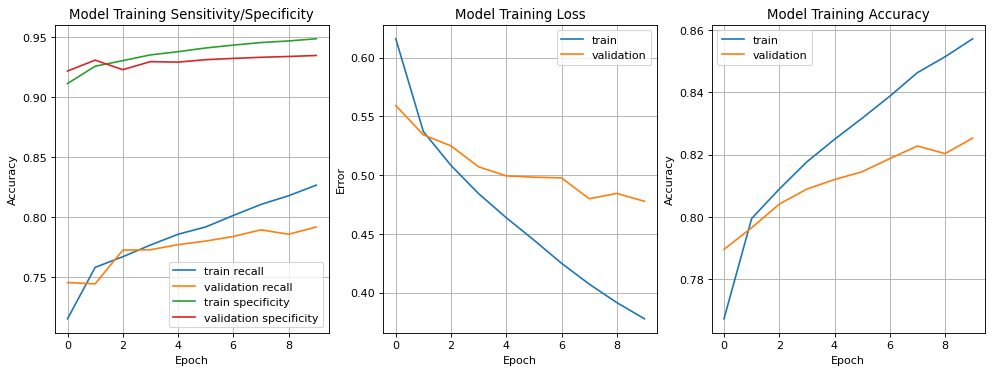

In [ ]:
# Define the function to calculate the specificity
def spec(a, b):
    return a / (a + b)

# Define a function to plot the sensitivity and specificity
def plotBalance(h, name):
    # Calculate the specificity
    specificity = list(map(spec, h.history['true_negatives'], h.history['false_positives']))
    val_specificity = list(map(spec, h.history['val_true_negatives'], h.history['val_false_positives']))

    # Plot the recall curve
    plt.plot(h.history['recall'], label='train recall')
    plt.plot(h.history['val_recall'], label='validation recall')

    # Plot the specificity curve
    plt.plot(specificity, label='train specificity')
    plt.plot(val_specificity, label='validation specificity')

    # Define the graph
    plt.title('{0} Training Sensitivity/Specificity'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Define a function to plot the loss curve
def plotLoss(h, name):
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='validation')
    plt.title('{0} Training Loss'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

# Plot the Accuracy curve
def plotAccuracy(h, name):
    plt.plot(h.history['Accuracy'], label='train')
    plt.plot(h.history['val_Accuracy'], label='validation')
    plt.title('{0} Training Accuracy'.format(name))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Define the sub-plot size
nCols = 3
nRows = 1

# Prepare the Loss Plots
plt.figure(figsize=(nCols * 5, nRows * 5), dpi=80)

# Plot the Sensitivity/Specificity
plt.subplot(nRows, nCols, 1)
plotBalance(history, 'Model')

# Plot the Loss
plt.subplot(nRows, nCols, 2)
plotLoss(history, 'Model')
    
# Plot the Accuracy
plt.subplot(nRows, nCols, 3)
plotAccuracy(history, 'Model')

# Draw the plots
plt.show()



## 8. Discussion and conclusions

Instructions: Write

- What settings and models were tested before the best model was found
    - What where the results of these experiments 
- Summary of  
    - What was your best model and its settings 
    - What was the final achieved performance 
- What are your main observations and learning points
- Discussion how the model could be improved in future 

**Note:** Remember to evaluate the final metrics using the test set. 
